## Applications of satellite gravimetry 

## 01- Load the necessary python modules

In [ ]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.vectorized import contains

## 02_Load Total Water Storage from 'TWS.nc' file

In [3]:
dsgrd = xr.open_dataset("TWS.nc")
dsgrd

<xarray.Dataset>
Dimensions:   (time: 162, lat: 181, lon: 361)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    tws       (lat, lon, time) float64 ...
    twsgauss  (lat, lon, time) float64 ...
    twsddk    (lat, lon, time) float64 ...

## 03_ Load basin geospatial data from GeoPackage files

In [4]:
data_dir = "data/basins"

basin_files = ["GREENLAND.gpkg","AMAZONAS.gpkg","CONGO.gpkg","DANUBE.gpkg","INDUS.gpkg","NILE.gpkg", "RHINE.gpkg", "GANGES.gpkg", "ARAL_DRAINAGE.gpkg", "LAKE_CHAD.gpkg", "MISSISSIPPI_RIVER.gpkg", "PARANA.gpkg"]

In [6]:
def basin_grid_points(basin, resolution, buffer):
    ds_basin=[]
    ds_basins1 = []  
    Basin_names = [] 
    

    for index in range(len(basin.geometry)):
        geom= basin.geometry.iloc[index]
        if geom.geom_type == 'Polygon':
            points = np.array(geom.exterior.coords[:-1]) 
            Basin_name = basin['name'][0] 


            x_min, x_max = int(np.min(points[:, 0])) - buffer, int(np.max(points[:, 0])) + buffer
            y_min, y_max = int(np.min(points[:, 1])) - buffer, int(np.max(points[:, 1])) + buffer

        elif geom.geom_type == 'MultiPolygon':
            all_points = []
            for polygon in geom.geoms:
                points = np.array(polygon.exterior.coords[:-1])  
                all_points.extend(points)

            all_points = np.array(all_points)
            Basin_name = basin['name'][0]


            x_min, x_max = int(np.min(all_points[:, 0])) - buffer, int(np.max(all_points[:, 0])) + buffer
            y_min, y_max = int(np.min(all_points[:, 1])) - buffer, int(np.max(all_points[:, 1])) + buffer


        x = np.arange(x_min, x_max, resolution)
        y = np.arange(y_min, y_max, resolution)


        X, Y = np.meshgrid(x, y)


        grid_points = np.column_stack([X.ravel(), Y.ravel()]) ## Creates a 2D matrix
        
        
        mask1 = contains(geom, grid_points[:, 0], grid_points[:, 1]) #1D array

        Basin_names.append(Basin_name) 
        inside_points = grid_points[mask1]

        

        ds_basin11 = xr.Dataset(coords = dict(lat = ("lat", inside_points[:,1]), lon = ("lon", inside_points[:,0])))
        

        ds_basins1.append(ds_basin11)  # Create a list of basins
        ds_basin = xr.concat(ds_basins1, dim="basin").assign_coords(basin=("basin", Basin_names)) ## assign th names of basins in the output


        return ds_basin

## 04_ Generate Basin Grid Points for Each Basin

In [7]:
resolution = 1
buffer = 5


basins_list = []

for basin_file in basin_files:
    
    fullpath = os.path.join(data_dir, basin_file)
    basin = gpd.read_file(fullpath)
    
    basin_coordinates = basin_grid_points(basin, resolution, buffer)
#    print(averaging_kernel)
    
    basins_list.append(basin_coordinates)

basins_list
#coordinates_all_basins = xr.concat(coordinates_list, dim="basin")
#coordinates_all_basins

[<xarray.Dataset>
 Dimensions:  (lat: 660, lon: 660, basin: 1)
 Coordinates:
   * lat      (lat) int64 61 61 61 61 61 61 62 62 62 ... 83 83 83 83 83 83 83 83
   * lon      (lon) int64 -48 -47 -46 -45 -44 -43 -49 ... -30 -29 -28 -27 -26 -25
   * basin    (basin) <U9 'Greenland'
 Data variables:
     *empty*,
 <xarray.Dataset>
 Dimensions:  (lat: 481, lon: 481, basin: 1)
 Coordinates:
   * lat      (lat) int64 -19 -19 -19 -19 -18 -18 -18 -18 -18 ... 3 3 3 4 4 4 4 5
   * lon      (lon) int64 -65 -64 -63 -62 -66 -65 -64 ... -60 -64 -62 -61 -60 -60
   * basin    (basin) <U8 'AMAZONAS'
 Data variables:
     *empty*,
 <xarray.Dataset>
 Dimensions:  (lat: 299, lon: 299, basin: 1)
 Coordinates:
   * lat      (lat) int64 -13 -13 -12 -12 -12 -12 -12 -11 -11 ... 7 7 7 7 7 8 8 8
   * lon      (lon) int64 29 30 19 28 29 30 31 19 20 ... 22 23 24 25 26 22 23 24
   * basin    (basin) <U5 'CONGO'
 Data variables:
     *empty*,
 <xarray.Dataset>
 Dimensions:  (lat: 94, lon: 94, basin: 1)
 Coordinates:
  

## 05_ Select a watershed and compute the TWS values for each grid point in the selected basin

In [8]:
latt = basins_list[0].coords['lat'].values.astype(int)
lonn = basins_list[0].coords['lon'].values.astype(int)


In [9]:
dseries=dsgrd.sel(lon=lonn,lat=latt)

In [10]:
dseries

<xarray.Dataset>
Dimensions:   (time: 162, lat: 660, lon: 660)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
  * lat       (lat) float64 61.0 61.0 61.0 61.0 61.0 ... 83.0 83.0 83.0 83.0
  * lon       (lon) float64 -48.0 -47.0 -46.0 -45.0 ... -28.0 -27.0 -26.0 -25.0
Data variables:
    tws       (lat, lon, time) float64 ...
    twsgauss  (lat, lon, time) float64 ...
    twsddk    (lat, lon, time) float64 ...

## 06_ Compute the weighted mean TWS time series for the selected basin

In [11]:
weights = np.cos(np.deg2rad(dseries.lat))
weights.name = "weights"

In [12]:
tws_weighted = dseries.weighted(weights)
tws_weighted

DatasetWeighted with weights along dimensions: lat

In [13]:
tws_weighted_mean = tws_weighted.mean(("lon", "lat")) #Each data point in dseries is multiplied by the corresponding weight in weights #source: https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html
tws_weighted_mean

<xarray.Dataset>
Dimensions:   (time: 162)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    tws       (time) float64 0.4439 0.5272 0.3272 ... -0.5009 -0.4175 -0.4883
    twsgauss  (time) float64 0.4485 0.4118 0.341 ... -0.3678 -0.3984 -0.4657
    twsddk    (time) float64 0.4296 0.4193 0.3572 ... -0.4116 -0.4288 -0.4773

## 07_ Plot Weighted Mean TWS for the selected basin

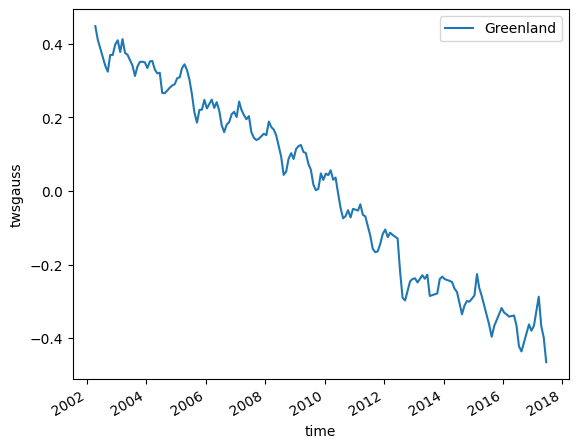

In [21]:
tws_weighted_mean.twsgauss.plot(label = "Greenland")
plt.legend()

## Analysis and Applications of TWS Time Series in Basins

## Basins:


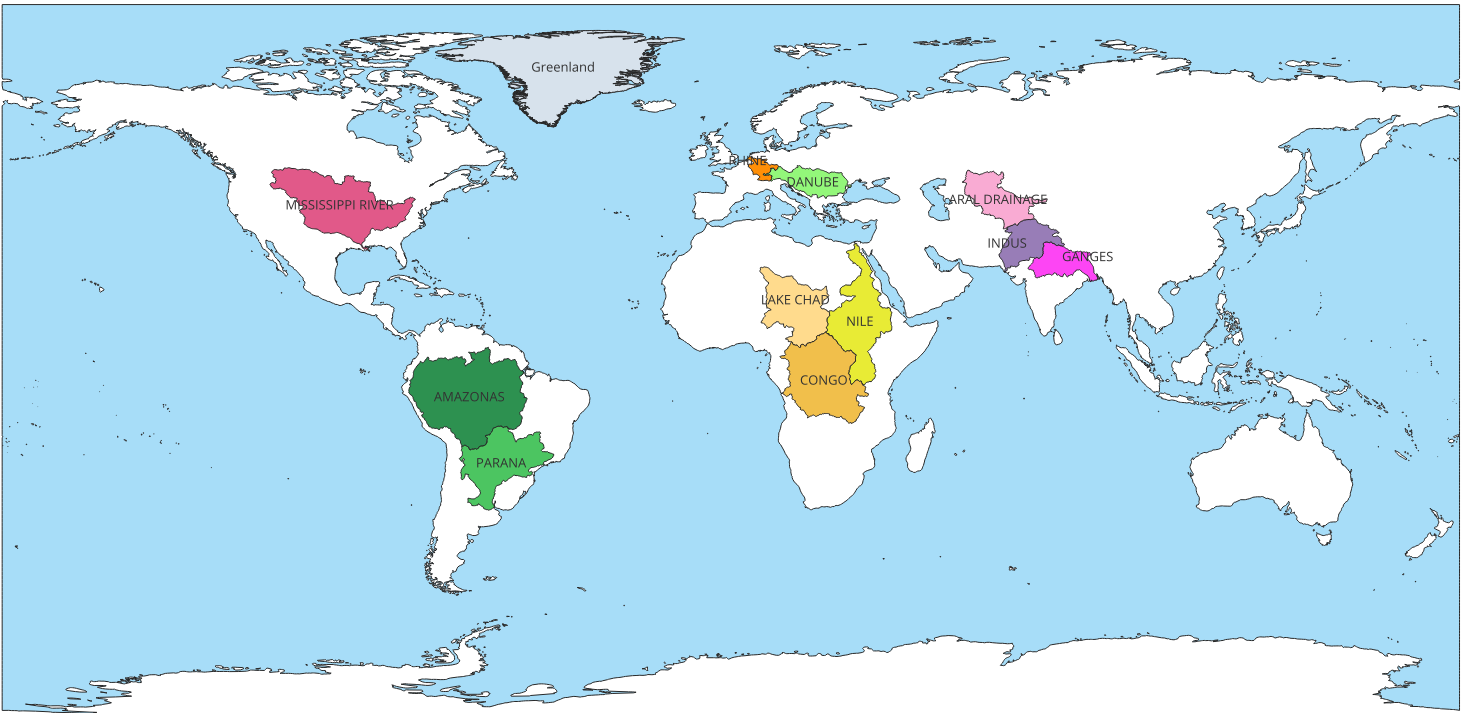

## Select three basins and create TWS time series. Explain what you see in these time series. Do you notice any differences between the locations? Try to find an explanation for what you are seeing.


## Explain the application of the TWS time series in your selected basins. Are there any specific extreme events that are happening? Do you think ice melting is occurring?

## Can you think of another application of the TWS time series that is not based on the selected basins?

## Choose one of the following questions to answer:

## How can groundwater be monitored using GRACE data?